# Imports, configs, etc

In [1]:
import numpy as np
import pandas as pd
import datetime
import pvlib
import clearsky_detect_model_free
import clearsky_detect_model_free_slow

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)
import filtering

import warnings
warnings.filterwarnings('ignore') # lots of warnings from numpy/scipy methods


%load_ext autoreload
%autoreload 2

%load_ext line_profiler

# Load irradiance data

## SNL

Weather and performance data are taken at 1min intervals.  Supplier is the Sandia National Lab Regional Test Center in Albuquerque, NM.  Data spans roughly 2016-April 2017.  This data was scraped from PVDAQ (http://bit.ly/2mKrOwG).  The meteorological data and the performance data are contained in two separate files (technically separate systems - PV system and meteorological station).

In [2]:
file = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1405_weather_for_1429.csv')
cols = ['Global_Wm2', 'Date-Time']
rtc_data = pd.read_csv(file, parse_dates=['Date-Time'], usecols=cols, index_col=['Date-Time'])
rtc_data.index = rtc_data.index.tz_localize('Etc/GMT+7')
rtc_data = rtc_data.reindex(
    pd.date_range(start=rtc_data.index[0], end=rtc_data.index[-1], freq='1min')
).fillna(0)
rtc_data = pd.Series(rtc_data['Global_Wm2'], index=rtc_data.index)
rtc_data[rtc_data < 0] = 0

# Set up PVLib system

## SNL

In [3]:
rtc_azimuth = 180
rtc_elevation = 1658
rtc_tilt = 35
rtc_lat = 35.0549
rtc_lon = -106.5433

In [4]:
rtc_no_loc = pvlib.pvsystem.PVSystem(surface_tilt=rtc_tilt, surface_azimuth=rtc_azimuth)
rtc_loc = pvlib.location.Location(rtc_lat, rtc_lon, altitude=rtc_elevation)
rtc = pvlib.pvsystem.LocalizedPVSystem(pvsystem=rtc_no_loc, location=rtc_loc)

# Analysis

In [5]:
def compare_plot(sample, is_clear1, label1, is_clear2, label2):
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10, 5))

    ax = axes[0]
    _ = ax.plot(sample.index, sample)
    _ = ax.scatter(sample.index[is_clear1 & ~is_clear2], sample[is_clear1 & ~is_clear2], 
               facecolor='none', edgecolor='green', label=label1)
    _ = ax.scatter(sample.index[is_clear2 & ~is_clear1], sample[is_clear2 & ~is_clear1], 
               facecolor='none', edgecolor='red', label=label2)
    _ = ax.scatter(sample.index[is_clear2 & is_clear1], sample[is_clear2 & is_clear1], 
               facecolor='none', edgecolor='yellow', label='both')
    _ = ax.legend()
    
    ax = axes[1]
    _ = ax.plot(is_clear1.index, np.cumsum(is_clear1.astype(int)), label=label1)
    _ = ax.plot(is_clear2.index, np.cumsum(is_clear2.astype(int)), label=label2)
    _ = ax.legend()
    
    fig.tight_layout()

## Samples from SNL

In [6]:
rtc_sample = rtc_data[(rtc_data.index >= '2016-07-01') & (rtc_data.index < '2016-07-08')]

In [7]:
%%timeit
rtc_clear_skies = rtc.get_clearsky(rtc_sample.index)
rtc_clear_skies = pd.Series(rtc_clear_skies['ghi'], index=rtc_sample.index)
rtc_pvlib_is_clear = pvlib.clearsky.detect_clearsky(rtc_sample, rtc_clear_skies, rtc_sample.index, 10)

1.56 s ± 33.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
rtc_clear_skies = rtc.get_clearsky(rtc_sample.index)
rtc_clear_skies = pd.Series(rtc_clear_skies['ghi'], index=rtc_sample.index)
rtc_pvlib_is_clear = pvlib.clearsky.detect_clearsky(rtc_sample, rtc_clear_skies, rtc_sample.index, 10)

### Standard method

In [9]:
fast_func = clearsky_detect_model_free.model_free_detect
slow_func = clearsky_detect_model_free_slow.model_free_detect

%timeit is_clear_fast = fast_func(rtc_sample)
%timeit is_clear_slow = slow_func(rtc_sample)

429 ms ± 5.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
29.1 s ± 874 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
is_clear_fast = fast_func(rtc_sample)

In [11]:
is_clear_slow = slow_func(rtc_sample)

In [12]:
is_clear_fast.equals(is_clear_slow)

True

<IPython.core.display.Javascript object>


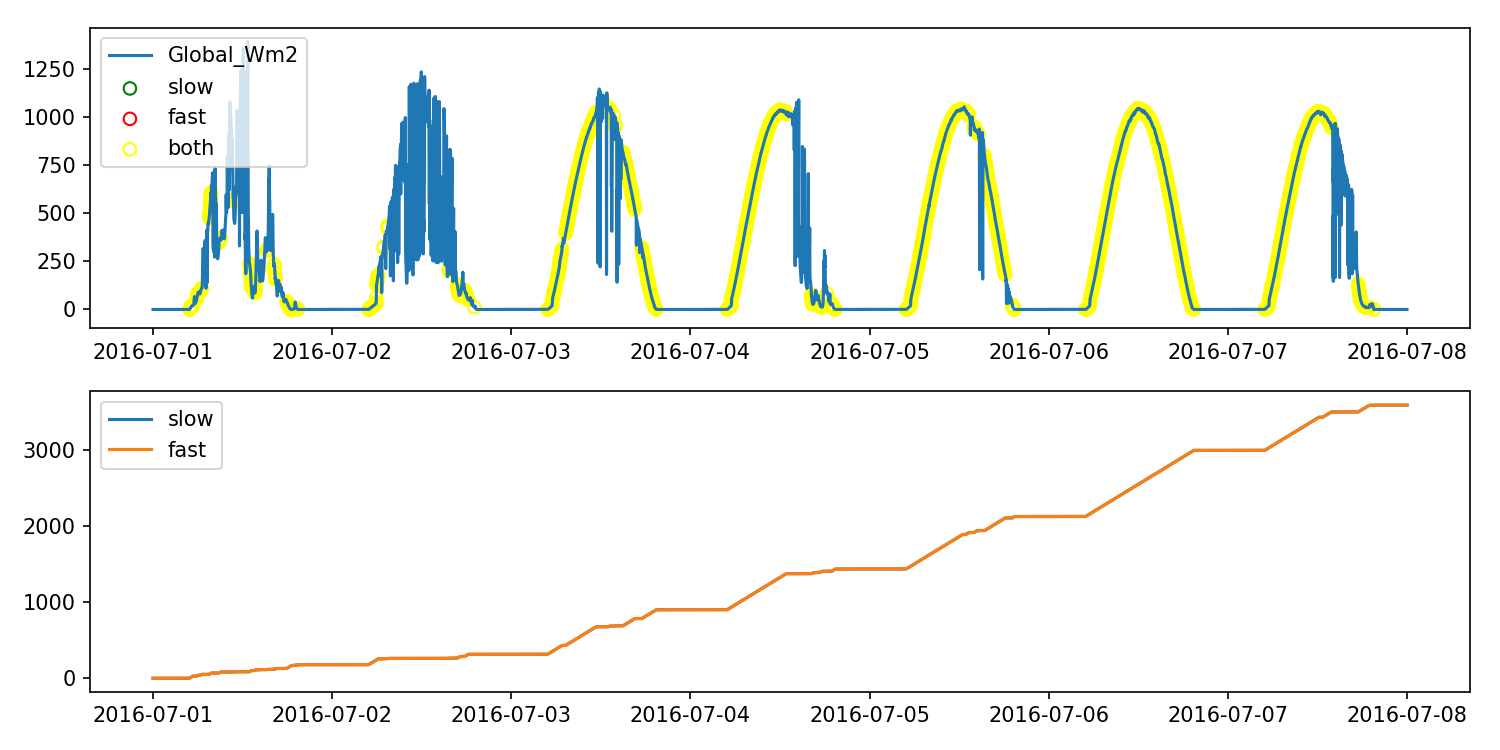

In [13]:
compare_plot(rtc_sample, is_clear_slow, 'slow', is_clear_fast, 'fast')

<IPython.core.display.Javascript object>


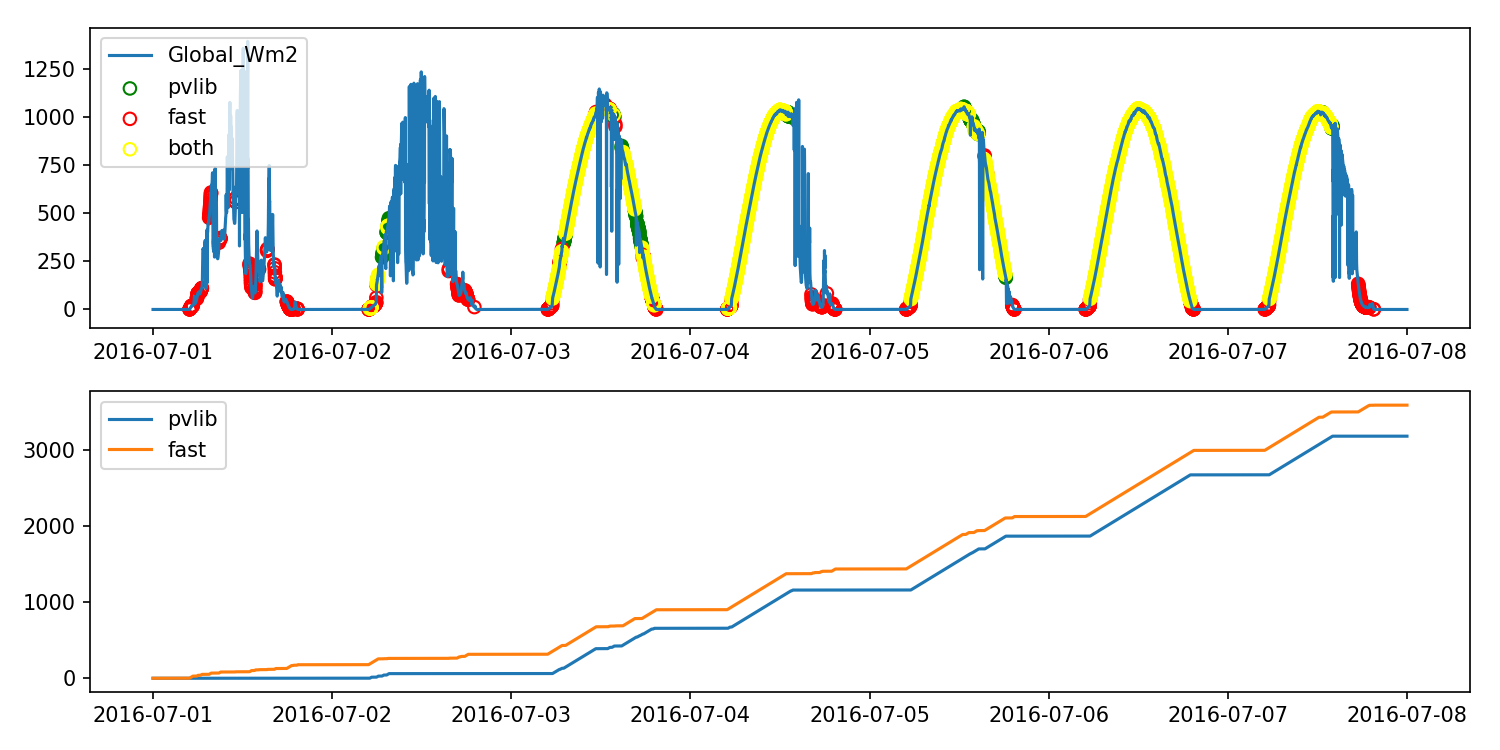

In [14]:
compare_plot(rtc_sample, rtc_pvlib_is_clear, 'pvlib', is_clear_fast, 'fast')

### Mean method

In [15]:
fast_func = clearsky_detect_model_free.model_free_detect_meanval
slow_func = clearsky_detect_model_free_slow.model_free_detect_meanval

%timeit is_clear_fast = fast_func(rtc_sample)
%timeit is_clear_slow = slow_func(rtc_sample)

630 ms ± 23.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
36.3 s ± 2.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
is_clear_fast = fast_func(rtc_sample)

In [17]:
is_clear_slow = slow_func(rtc_sample)

In [18]:
is_clear_fast.equals(is_clear_slow)

True

<IPython.core.display.Javascript object>


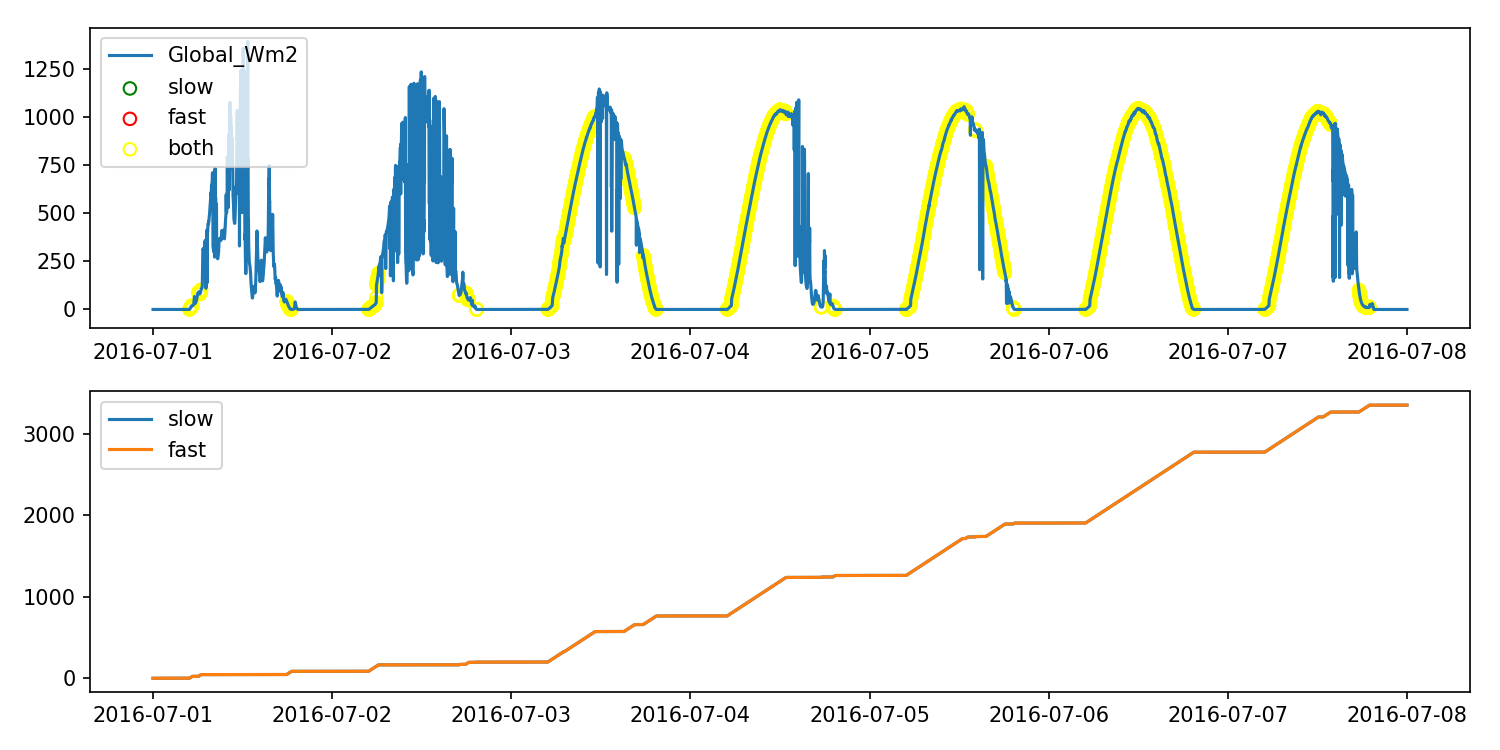

In [19]:
compare_plot(rtc_sample, is_clear_slow, 'slow', is_clear_fast, 'fast')

<IPython.core.display.Javascript object>


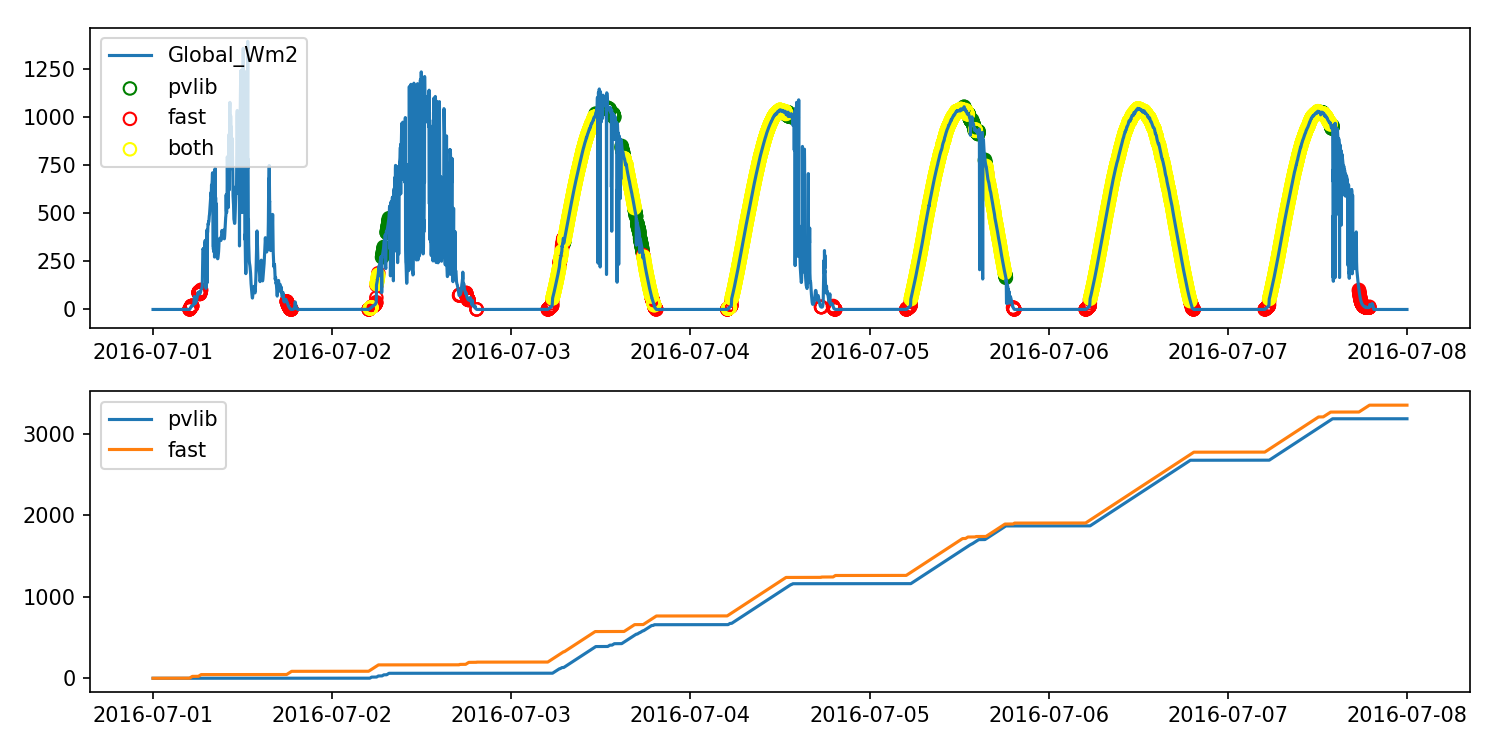

In [20]:
compare_plot(rtc_sample, rtc_pvlib_is_clear, 'pvlib', is_clear_fast, 'fast')

### Democratic method

In [21]:
fast_func = clearsky_detect_model_free.model_free_detect_democratic
slow_func = clearsky_detect_model_free_slow.model_free_detect_democratic

%timeit is_clear_fast = fast_func(rtc_sample)
%timeit is_clear_slow = slow_func(rtc_sample)

596 ms ± 8.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
38.5 s ± 1.55 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
is_clear_fast = fast_func(rtc_sample)

In [23]:
is_clear_slow = slow_func(rtc_sample)

In [24]:
is_clear_fast.equals(is_clear_slow)

False

<IPython.core.display.Javascript object>


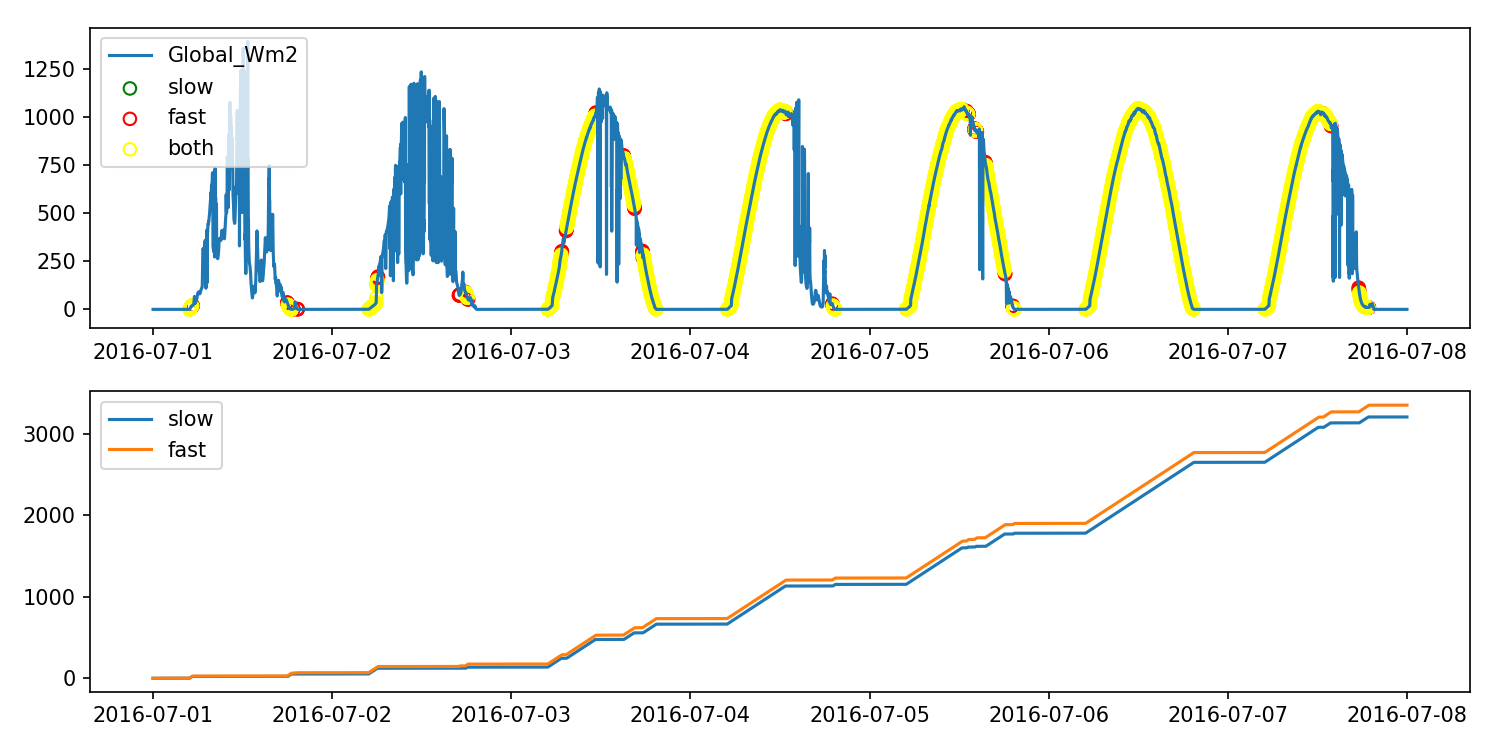

In [25]:
compare_plot(rtc_sample, is_clear_slow, 'slow', is_clear_fast, 'fast')

<IPython.core.display.Javascript object>


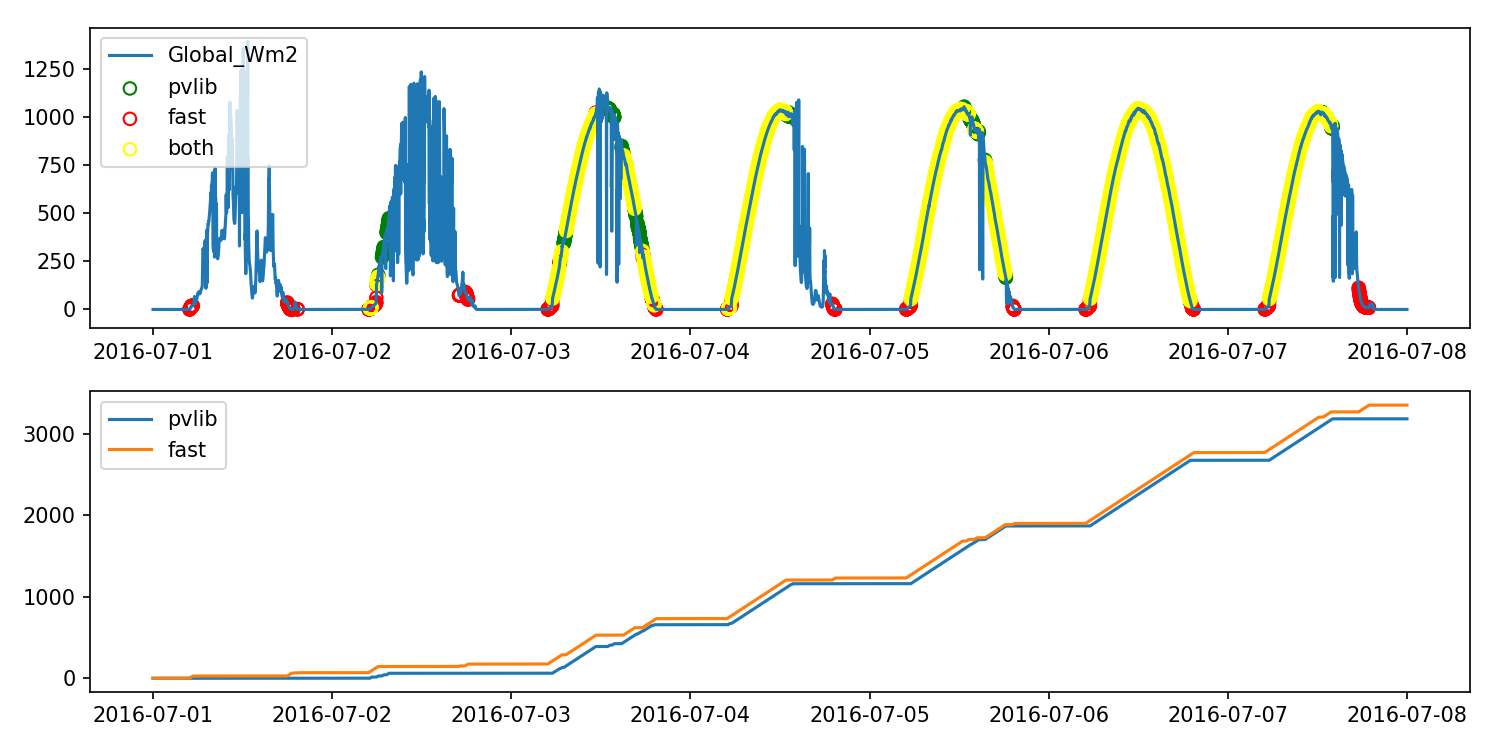

In [26]:
compare_plot(rtc_sample, rtc_pvlib_is_clear, 'pvlib', is_clear_fast, 'fast')